# Customer Churn Prediction

Vincent Luong

## Introduction: Predicting Customer Churn in Subscription-Based Services

In recent years, monthly subscription-based services have surged in popularity, spanning industries such as streaming (e.g., Netflix, Spotify), SaaS (Software as a Service), fitness (e.g., Peloton), and e-commerce (e.g., Amazon Prime). These models offer convenience and consistent revenue streams, making them an attractive business strategy. However, they also introduce a critical metric to monitor: **customer churn**.

**Customer Churn**: refers to the percentage of customers who cancel or stop renewing their subcriptions during a given time period.  High churn rates can significantlyt impact revenue and long-term growth, especially in competitive markets were acquiring new customers is often more expenstive then retaining existing ones.

To mitigate churn and retain consumers, we can implement strategies such as:
- Personalized offers and retention campaigns
- Improving onboarding and customer support
- Monitoring engagement metrics to intervene before customers churn

To stay ahead of potential losses, we can utilize data-driven churn prediction models that help us act proactively rather than reactively. These models analyze customer behavior and identify individuals who are at a high risk of leaving, allowing companies to intervene before it’s too late. Common machine learning approaches used for predicting churn include:
- **Logistic Regression**: A simple and interpretable baseline model for binary classification
- **Decision Trees and Random Forests**: Useful for capturing nonlinear patterns and feature importance
- **Gradient Boosting Machines**: Models such as XGBoost and LightGBM are power ensemble methods with strong predictive performance
- **Neural Networks**: Applied for complex. high-dimensional data scenarios
- **Survival Analysis**: Useful when modeling when a customer will churn, not just if.

In this project, we aim to develop a machine learning model to predict whether a customer is likely to churn based on historical subscription and behavioral data introduced below. This prediction can empower businesses to make informed decisions that reduce churn and enhance customer lifetime value.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as ss
from scipy.stats import skew

### Data

The [Telco Customer Churn dataset 11.1.3+](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data), originally provided by IBM and hosted on Kaggle, offers detailed information about a telecommunications company's customers and their subscription behavior. It contains 7,043 customer records with 33 features, covering demographics, account details, and service usage patterns. The dataset has been updated to include more comprehensive information, providing deeper insights into customer behavior and churn factors.

Features Include:

🔑 Identifiers & Location
1. `CustomerID`: A unique ID that identifies each customer
2. `Count`: A value used in reporting/dashboarding to sum up the number of customers in a filtered set
3. `Country`: The country of the customer's primary residence
4. `State`: The state of hte customer's primary residence
5. `City`: The city of hte customer's primary residence
6. `Zip Code`: The zip code of the customer's primary residence
7. `Lat Long`: The combined latitude and longitude of the customer's primary residence
8. `Lattitude`: The latitude of the customer's primary residence
9. `Longitude`: The longitude of the customer's primary residence
    
👤 Demographics
1. `Age`: A numerical feature incdicating the age of a customer
2. `Married`: A binary feature indicating whether the customer is married (0 or 1)
3. `Dependents`: Whether the customer has dependents or not (Yes or No)
4. `Number of Dependents`: A numerical feature indicating the number of dependents a customer has
5. `Referred a Friend`: A binary feature indicating whether a customer has referred a friend (0 or 1)
6. `Number of Referrals`: A numerical feature indicatin the number of referrals a customer has given
   
⏳ Customer Tenure
1. `Tenure Months`:  Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above

📞 Services Subscribed
1. `PhoneService`: Indicates if the customer subscribes to home phone service with the company (Yes, No)
2. `MultipleLines`:  Indicates if the customer subscribes to multiple telephone lines with the company (Yes, No)
3. `InternetService`: Indicates if the customer subscribes to Internet service with the company (No, DSL, Fiber Optic, Cable)
4. `OnlineSecurity`: Indicates if the customer subscribes to an additional online security service provided by the company (Yes, No)
5. `OnlineBackup`: Indicates if the customer subscribes to an additional online backup service provided by the company (Yes, No)
6. `Device Protection`: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company (Yes, No)
7. `Tech Support`: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times (Yes, No)
8. `Streaming TV`: Indicates if the customer uses their Internet service to stream television programing from a third party provider (Yes, No, The company does not charge an additional fee for this service)
9. `Streaming Movies`: Indicates if the customer uses their Internet service to stream movies from a third party provider (Yes, No, The company does not charge an additional fee for this service)

💳 Billing & Payment
1. `Contract`: Indicates the customer’s current contract type (Month-to-Month, One Year, Two Year)
2. `Paperless Billing`: Indicates if the customer has chosen paperless billing (Yes, No)
3. `Payment Method`: Indicates how the customer pays their bill (Bank Withdrawal, Credit Card, Mailed Check)
4. `Monthly Charge`: Indicates the customer’s current total monthly charge for all their services from the company.
5. `Total Charges`: Indicates the customer's total charges, calulated to the end of the quarter specified above.

🔍 Churn-Related Information
1. `Churn Label`: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.
2. `Churn Value`: 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.
3. `Churn Score`: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.
4. `CLTV`: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.
5. `Churn Reason`:  A customer’s specific reason for leaving the company. Directly related to Churn Category.

In [2]:
df_telco = pd.read_excel('data/Telco_customer_churn.xlsx').drop(columns=['Count','Country','State', 'Zip Code','Lat Long','Latitude','Longitude','Payment Method','Churn Label'])
df_demo = pd.read_excel('data/Telco_customer_churn_demographics.xlsx').drop(columns=['Gender','Senior Citizen','Dependents','Under 30','Count']).rename(columns={'Customer ID':'CustomerID'})
df_services = pd.read_excel('data/Telco_customer_churn_services.xlsx').drop(columns=['Count','Quarter','Tenure in Months','Phone Service','Multiple Lines','Internet Type','Internet Service','Online Security','Online Backup','Device Protection Plan','Streaming TV','Streaming Movies','Contract','Paperless Billing','Monthly Charge','Total Charges']).rename(columns={'Customer ID':'CustomerID'})
df_churn = pd.read_excel('data/Telco_customer_churn_status.xlsx').drop(columns=['Count','Quarter','Churn Label','Churn Value','Churn Reason','Churn Score','CLTV']).rename(columns={'Customer ID':'CustomerID'})
df = pd.merge(left=df_telco,right=df_demo, on='CustomerID').merge(right=df_services, on='CustomerID').merge(right=df_churn,on='CustomerID').rename(columns={'Churn Value':'Churn'}).drop(columns=['CustomerID','Tech Support'])
demo_graph_var = ['Gender','Age','Senior Citizen', 'Married', 'Dependents','Number of Dependents']
services_var = ['Referred a Friend','Number of Referrals','Tenure Months','Offer','Phone Service','Avg Monthly Long Distance Charges','Multiple Lines','Internet Service','Avg Monthly GB Download','Online Security','Online Backup','Device Protection','Premium Tech Support','Streaming TV','Streaming Movies','Streaming Music','Unlimited Data','Contract','Paperless Billing','Payment Method','Monthly Charges','Total Charges','Total Refunds','Total Extra Data Charges','Total Long Distance Charges','Total Revenue']
con_dat = df[demo_graph_var+services_var+['Churn Category']+['Churn']]

con_dat.head()

,Gender,Age,Senior Citizen,Married,Dependents,Number of Dependents,Referred a Friend,Number of Referrals,Tenure Months,Offer,...,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Category,Churn
0,Male,37,No,No,No,0,No,0,2,None,...,Yes,Credit Card,53.85,108.15,0.0,0,20.94,129.09,Competitor,1
1,Female,19,No,No,Yes,2,No,0,2,None,...,Yes,Bank Withdrawal,70.70,151.65,0.0,0,18.24,169.89,Other,1
2,Female,31,No,No,Yes,2,No,0,8,None,...,Yes,Bank Withdrawal,99.65,820.5,0.0,0,97.20,917.70,Other,1
3,Female,23,No,Yes,Yes,3,No,0,28,Offer C,...,Yes,Bank Withdrawal,104.80,3046.05,0.0,0,136.92,3182.97,Other,1
4,Male,38,No,No,Yes,1,No,0,49,None,...,Yes,Bank Withdrawal,103.70,5036.3,0.0,0,2172.17,7208.47,Competitor,1


In [3]:
con_dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   object 
 1   Age                                7043 non-null   int64  
 2   Senior Citizen                     7043 non-null   object 
 3   Married                            7043 non-null   object 
 4   Dependents                         7043 non-null   object 
 5   Number of Dependents               7043 non-null   int64  
 6   Referred a Friend                  7043 non-null   object 
 7   Number of Referrals                7043 non-null   int64  
 8   Tenure Months                      7043 non-null   int64  
 9   Offer                              7043 non-null   object 
 10  Phone Service                      7043 non-null   object 
 11  Avg Monthly Long Distance Charges  7043 non-null   float

In [4]:
df_services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   CustomerID                         7043 non-null   object 
 1   Referred a Friend                  7043 non-null   object 
 2   Number of Referrals                7043 non-null   int64  
 3   Offer                              7043 non-null   object 
 4   Avg Monthly Long Distance Charges  7043 non-null   float64
 5   Avg Monthly GB Download            7043 non-null   int64  
 6   Premium Tech Support               7043 non-null   object 
 7   Streaming Music                    7043 non-null   object 
 8   Unlimited Data                     7043 non-null   object 
 9   Payment Method                     7043 non-null   object 
 10  Total Refunds                      7043 non-null   float64
 11  Total Extra Data Charges           7043 non-null   int64

From the dataset above, we observe that the columns `Churn Label` and `Churn Value` are directly correlated, with a one-to-one relationship. Including both as target variables would introduce redundancy and could lead to artificially inflated model performance. To avoid this, we will remove `Churn Label` and use only `Churn Value` as our target variable during the train/test split.

## Explanatory Data Analysis

**Exploratory Data Analysis** (EDA) is the process of investigating and summarizing the key characteristics of a dataset before applying any modeling techniques. It helps uncover patterns, spot anomalies, identify missing values, test assumptions, and gain insights into the structure of the data. Through visualizations and statistical summaries, EDA allows us to help make informed data-driven decisions about data cleaning, feature engineering, and model selection, ensuring that the data is well-understood and ready for analysis.

### Data Shape and Data Types

Below, we examine the structure of the dataset by displaying its shape, which includes the number of rows and columns, as well as the data types of each feature. This helps us understand what kind of preprocessing may be required.

In [5]:
con_dat.shape

(7043, 34)

In [6]:
con_dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   object 
 1   Age                                7043 non-null   int64  
 2   Senior Citizen                     7043 non-null   object 
 3   Married                            7043 non-null   object 
 4   Dependents                         7043 non-null   object 
 5   Number of Dependents               7043 non-null   int64  
 6   Referred a Friend                  7043 non-null   object 
 7   Number of Referrals                7043 non-null   int64  
 8   Tenure Months                      7043 non-null   int64  
 9   Offer                              7043 non-null   object 
 10  Phone Service                      7043 non-null   object 
 11  Avg Monthly Long Distance Charges  7043 non-null   float

Above, we see that `Total Charges` is read as an object, but we need it as a float value.

In [7]:
con_dat['Total Charges'] = pd.to_numeric(con_dat['Total Charges'], errors='coerce')
con_dat['Total Charges'].head()

C:\Users\vince\AppData\Local\Temp\ipykernel_5868\1763632050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  con_dat['Total Charges'] = pd.to_numeric(con_dat['Total Charges'], errors='coerce')


0     108.15
1     151.65
2     820.50
3    3046.05
4    5036.30
Name: Total Charges, dtype: float64

#### Missing Values

We will analyze missing values to ensure the quality and reliability of our data before performing any analysis or building predictive models.  Missing values can lead to biased results, reduce model accuracy, and cause errors during processing. Identifying and handling them appropriately helps maintain the integrity of the dataset and ensures that the insights or predictions we generate are based on complete and meaningful information.

In [8]:
con_dat.isnull().sum()

Gender                                  0
Age                                     0
Senior Citizen                          0
Married                                 0
Dependents                              0
Number of Dependents                    0
Referred a Friend                       0
Number of Referrals                     0
Tenure Months                           0
Offer                                   0
Phone Service                           0
Avg Monthly Long Distance Charges       0
Multiple Lines                          0
Internet Service                        0
Avg Monthly GB Download                 0
Online Security                         0
Online Backup                           0
Device Protection                       0
Premium Tech Support                    0
Streaming TV                            0
Streaming Movies                        0
Streaming Music                         0
Unlimited Data                          0
Contract                          

#### Missing Values Rationale

From the dataset, we observe some **non-response bias**, as certain customers did not provide a reason for why they churned as there are *n=5174* missing values for `Churn Category`. Aside from this, the remaining features appear relatively clean, with no missing values present.

On the contary, we see that there are a total of **11** missing values for `Total Charges`, we will explore the missing values below

In [9]:
con_dat[con_dat['Total Charges'].isnull()]

,Gender,Age,Senior Citizen,Married,Dependents,Number of Dependents,Referred a Friend,Number of Referrals,Tenure Months,Offer,...,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Category,Churn
2234,Female,43,No,Yes,No,0,Yes,2,0,None,...,Yes,Bank Withdrawal,52.55,NaN,0.0,0,0.0,525.50,NaN,0
2438,Male,24,No,No,No,0,No,0,0,None,...,No,Credit Card,20.25,NaN,0.0,0,131.6,334.10,NaN,0
2568,Female,40,No,Yes,No,0,Yes,8,0,None,...,No,Mailed Check,80.85,NaN,0.0,0,310.9,1119.40,NaN,0
2667,Male,39,No,Yes,Yes,1,Yes,5,0,None,...,No,Credit Card,25.75,NaN,0.0,0,228.3,485.80,NaN,0
2856,Female,64,No,Yes,No,0,Yes,2,0,None,...,No,Credit Card,56.05,NaN,0.0,0,0.0,560.50,NaN,0
4331,Male,56,No,Yes,Yes,1,Yes,5,0,None,...,No,Credit Card,19.85,NaN,0.0,0,155.1,353.60,NaN,0
4687,Male,22,No,Yes,Yes,2,Yes,3,0,None,...,No,Credit Card,25.35,NaN,0.0,0,363.7,617.20,NaN,0
5104,Female,23,No,Yes,Yes,3,Yes,4,0,Offer E,...,No,Credit Card,20.00,NaN,0.0,0,200.5,400.50,NaN,0
5719,Male,38,No,Yes,Yes,2,Yes,5,0,Offer E,...,Yes,Credit Card,19.70,NaN,0.0,0,462.3,659.84,NaN,0
6772,Female,25,No,Yes,Yes,3,Yes,6,0,Offer E,...,No,Credit Card,73.35,NaN,0.0,0,55.9,789.40,NaN,0


From the above dataframe, we see that those have **0** `Total Charges` are typically customers with **0** Tenure Months and have existing `Monthly Charges`.  This can indicate that they are probably a brand-new customer and we will impute the `Total Charges` to **0** for those specific indexes and treat them as customers who are new and have not been charged yet.

#### 0 Values For Numerical Features

Some features such as `Monthly Charges`, `Total Charges` or `Tenure Months` would not make sense if their values were 0, meaning that imputation might be necessary towards these values

In [10]:
con_dat[con_dat['Tenure Months'] == 0]

,Gender,Age,Senior Citizen,Married,Dependents,Number of Dependents,Referred a Friend,Number of Referrals,Tenure Months,Offer,...,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Category,Churn
2234,Female,43,No,Yes,No,0,Yes,2,0,None,...,Yes,Bank Withdrawal,52.55,NaN,0.0,0,0.0,525.50,NaN,0
2438,Male,24,No,No,No,0,No,0,0,None,...,No,Credit Card,20.25,NaN,0.0,0,131.6,334.10,NaN,0
2568,Female,40,No,Yes,No,0,Yes,8,0,None,...,No,Mailed Check,80.85,NaN,0.0,0,310.9,1119.40,NaN,0
2667,Male,39,No,Yes,Yes,1,Yes,5,0,None,...,No,Credit Card,25.75,NaN,0.0,0,228.3,485.80,NaN,0
2856,Female,64,No,Yes,No,0,Yes,2,0,None,...,No,Credit Card,56.05,NaN,0.0,0,0.0,560.50,NaN,0
4331,Male,56,No,Yes,Yes,1,Yes,5,0,None,...,No,Credit Card,19.85,NaN,0.0,0,155.1,353.60,NaN,0
4687,Male,22,No,Yes,Yes,2,Yes,3,0,None,...,No,Credit Card,25.35,NaN,0.0,0,363.7,617.20,NaN,0
5104,Female,23,No,Yes,Yes,3,Yes,4,0,Offer E,...,No,Credit Card,20.00,NaN,0.0,0,200.5,400.50,NaN,0
5719,Male,38,No,Yes,Yes,2,Yes,5,0,Offer E,...,Yes,Credit Card,19.70,NaN,0.0,0,462.3,659.84,NaN,0
6772,Female,25,No,Yes,Yes,3,Yes,6,0,Offer E,...,No,Credit Card,73.35,NaN,0.0,0,55.9,789.40,NaN,0


In [11]:
con_dat[con_dat['Total Charges'] == 0]

,Gender,Age,Senior Citizen,Married,Dependents,Number of Dependents,Referred a Friend,Number of Referrals,Tenure Months,Offer,...,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Category,Churn


In [12]:
con_dat[con_dat['Total Charges'].isnull()]

,Gender,Age,Senior Citizen,Married,Dependents,Number of Dependents,Referred a Friend,Number of Referrals,Tenure Months,Offer,...,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Category,Churn
2234,Female,43,No,Yes,No,0,Yes,2,0,None,...,Yes,Bank Withdrawal,52.55,NaN,0.0,0,0.0,525.50,NaN,0
2438,Male,24,No,No,No,0,No,0,0,None,...,No,Credit Card,20.25,NaN,0.0,0,131.6,334.10,NaN,0
2568,Female,40,No,Yes,No,0,Yes,8,0,None,...,No,Mailed Check,80.85,NaN,0.0,0,310.9,1119.40,NaN,0
2667,Male,39,No,Yes,Yes,1,Yes,5,0,None,...,No,Credit Card,25.75,NaN,0.0,0,228.3,485.80,NaN,0
2856,Female,64,No,Yes,No,0,Yes,2,0,None,...,No,Credit Card,56.05,NaN,0.0,0,0.0,560.50,NaN,0
4331,Male,56,No,Yes,Yes,1,Yes,5,0,None,...,No,Credit Card,19.85,NaN,0.0,0,155.1,353.60,NaN,0
4687,Male,22,No,Yes,Yes,2,Yes,3,0,None,...,No,Credit Card,25.35,NaN,0.0,0,363.7,617.20,NaN,0
5104,Female,23,No,Yes,Yes,3,Yes,4,0,Offer E,...,No,Credit Card,20.00,NaN,0.0,0,200.5,400.50,NaN,0
5719,Male,38,No,Yes,Yes,2,Yes,5,0,Offer E,...,Yes,Credit Card,19.70,NaN,0.0,0,462.3,659.84,NaN,0
6772,Female,25,No,Yes,Yes,3,Yes,6,0,Offer E,...,No,Credit Card,73.35,NaN,0.0,0,55.9,789.40,NaN,0


In [13]:
con_dat[con_dat['Monthly Charges'] == 0].head()

,Gender,Age,Senior Citizen,Married,Dependents,Number of Dependents,Referred a Friend,Number of Referrals,Tenure Months,Offer,...,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Category,Churn


As seen from the dataframes generated above, we can discover that there are for all **NaN** values, they have **0** for the amount for `Tenure Months` further explaining that they are a new customer.  For that reason, we will impute **0** for the missing values of `Total Charges`.

In [14]:
#con_dat['Total Charges'].fillna(con_dat['Total Charges'].median(), inplace=True)
con_dat['Total Charges'].fillna(0, inplace=True)

pd.DataFrame(con_dat['Total Charges'])

C:\Users\vince\AppData\Local\Temp\ipykernel_5868\3561923007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  con_dat['Total Charges'].fillna(0, inplace=True)


,Total Charges
0,108.15
1,151.65
2,820.50
3,3046.05
4,5036.30
...,...
7038,1419.40
7039,1990.50
7040,7362.90
7041,346.45


#### Missing Churn Categories

As explored above, we saw that `Churn Category` had a bunch of missing values, let's first discover the missing values and see whether they have any correlation with anything

In [15]:
con_dat['Churn Category'].isnull().sum()

5174

In [16]:
con_dat.loc[con_dat['Churn Category'].isnull(), 
            ['Churn', 'Churn Category']]

,Churn,Churn Category
1869,0,NaN
1870,0,NaN
1871,0,NaN
1872,0,NaN
1873,0,NaN
...,...,...
7038,0,NaN
7039,0,NaN
7040,0,NaN
7041,0,NaN


In [17]:
con_dat.loc[
    (con_dat['Churn'] == 1) & (con_dat['Churn Category'].isnull()),
    ['Churn', 'Churn Category']
]

,Churn,Churn Category


In [18]:
con_dat['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [19]:
con_dat.shape

(7043, 34)

In [20]:
non_null_churn_cat = df['Churn Category'].notna().sum()
null_churn_cat = df['Churn Category'].isna().sum()

print(f"Non-null values: {non_null_churn_cat}")
print(f"Missing values: {null_churn_cat}")

Non-null values: 1869
Missing values: 5174


Exploring the number of counts, we see that number of non-churns matched the number of those who did not provide a reason.  Conversely, those who have churned, have an existing `Churn Category` value.  This would indicate that for those who provided a reason, they have churned.  Of course this would provide a *one-to-one* reason correlation to predicing churn, thus it would be reasonable to drop this feature as we want to predict those who are going to churn.  We will drop this category a bit later once we have found out some reasons consumer churn.

In [21]:
#con_dat = con_dat.drop(columns=["Churn Category"])

#con_dat.info()

#### Unique Features

Unique features help us better understand the structure and variability of our dataset.  Identifying the number of unique values in each feature helps determine whether a feature is categorical, binary, or continuous, and whether its suitable for analysis or modeling.  It also helps us detect potential issues such as constant columns with no variability, which provide little to no predictive power and may be removed.  Understanding uniqueness ensures we handle features appropriately during preprocessing and model training.

In [22]:
con_dat.select_dtypes(include='object').nunique()

Gender                  2
Senior Citizen          2
Married                 2
Dependents              2
Referred a Friend       2
Offer                   6
Phone Service           2
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Device Protection       3
Premium Tech Support    2
Streaming TV            3
Streaming Movies        3
Streaming Music         2
Unlimited Data          2
Contract                3
Paperless Billing       2
Payment Method          3
Churn Category          5
dtype: int64

In [23]:
con_dat.select_dtypes(include=['int64', 'float64']).nunique()

Age                                    62
Number of Dependents                   10
Number of Referrals                    12
Tenure Months                          73
Avg Monthly Long Distance Charges    3584
Avg Monthly GB Download                50
Monthly Charges                      1585
Total Charges                        6531
Total Refunds                         500
Total Extra Data Charges               16
Total Long Distance Charges          6110
Total Revenue                        6996
Churn                                   2
dtype: int64

From the dataset above, we observe that all of these features contain more than 1 unique value, thus indicating that these features have the ability to have some predictive power on our model.  We will further explore these features in our **EDA** section

We will first explore our *Object* type or categorical features below.

In [24]:
con_dat.select_dtypes(include='object').nunique()

Gender                  2
Senior Citizen          2
Married                 2
Dependents              2
Referred a Friend       2
Offer                   6
Phone Service           2
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Device Protection       3
Premium Tech Support    2
Streaming TV            3
Streaming Movies        3
Streaming Music         2
Unlimited Data          2
Contract                3
Paperless Billing       2
Payment Method          3
Churn Category          5
dtype: int64

### Churn Reasons Distributions

Beneath, we analyze the reasons why customers have churned in order to gain deeper insights that can help improve customer retention strategies.  Although we are not including this feature in our final model, this graph can hopefully provide further insight in how we can fix our company and retain customers.

In [25]:
con_dat['Churn Category'].value_counts()

Competitor         841
Attitude           314
Dissatisfaction    303
Price              211
Other              200
Name: Churn Category, dtype: int64

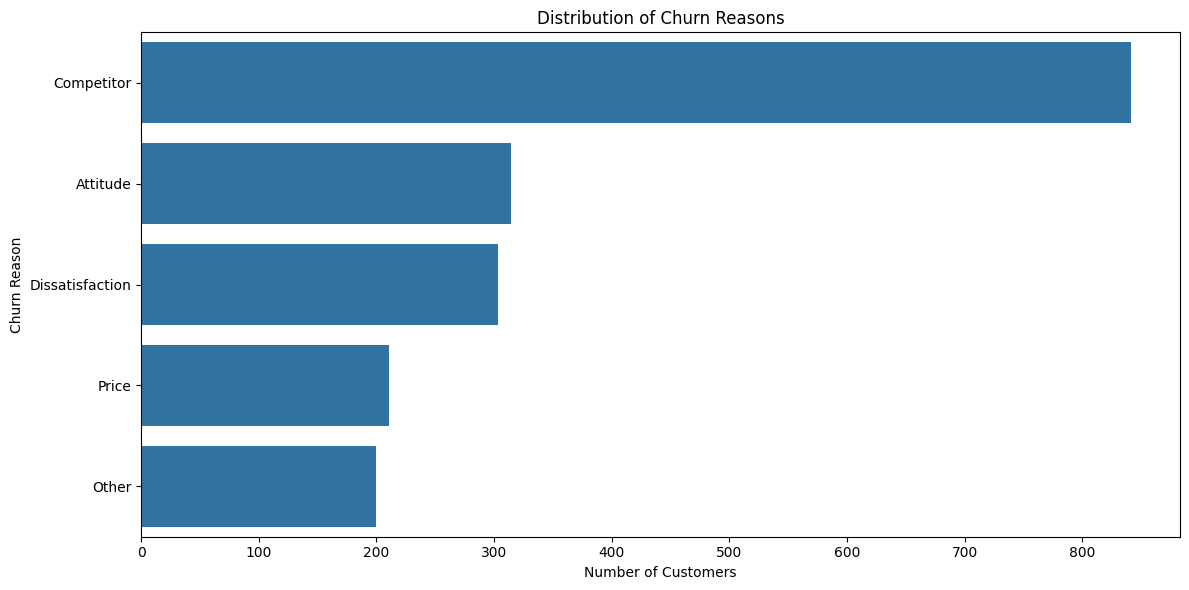

In [26]:
# Set figure size
plt.figure(figsize=(12, 6))

# Plot
sns.countplot(y='Churn Category', data=con_dat, order=con_dat['Churn Category'].value_counts().index)

# Add titles and labels
plt.title('Distribution of Churn Reasons')
plt.xlabel('Number of Customers')
plt.ylabel('Churn Reason')
plt.tight_layout()
plt.show()

From the visualizations above, we observe that many customers churn due to issues related to fierce competitors, attitude from customer support, and dissatisfaction from product.  Since our main goal is prediction, we will drop this category as it provides a 1:1 correlation with `Churn`, but it is good to understand the dataset and underyling issues with consumers.

In [27]:
con_dat = con_dat.drop(columns=["Churn Category"])

con_dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   object 
 1   Age                                7043 non-null   int64  
 2   Senior Citizen                     7043 non-null   object 
 3   Married                            7043 non-null   object 
 4   Dependents                         7043 non-null   object 
 5   Number of Dependents               7043 non-null   int64  
 6   Referred a Friend                  7043 non-null   object 
 7   Number of Referrals                7043 non-null   int64  
 8   Tenure Months                      7043 non-null   int64  
 9   Offer                              7043 non-null   object 
 10  Phone Service                      7043 non-null   object 
 11  Avg Monthly Long Distance Charges  7043 non-null   float

#### Summary Statistics

Below are the summary statistics about the dataset. These summary statistics provides a quick overview of the central tendency, spread, and distribution of numerical features. It helps identify outliers, anomalies, and potential data entry errors, such as unexpected negative values. Differences between metrics like the mean and median can reveal skewed distributions, which may require transformation before modeling. Summary statistics also allow for easy comparison between features, guiding decisions on normalization or feature scaling. Overall, this step ensures that you understand the structure and quality of your data before moving forward with analysis or modeling.

In [28]:
con_dat.describe()

,Age,Number of Dependents,Number of Referrals,Tenure Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charges,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,1.951867,32.371149,22.958954,20.515405,64.761692,2279.734304,1.962182,6.860713,749.099262,3034.379056,0.265370
std,16.750352,0.962802,3.001199,24.559481,15.448113,20.418940,30.090047,2266.794470,7.902614,25.104978,846.660055,2865.204542,0.441561
min,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,21.360000,0.000000
25%,32.000000,0.000000,0.000000,9.000000,9.210000,3.000000,35.500000,398.550000,0.000000,0.000000,70.545000,605.610000,0.000000
50%,46.000000,0.000000,0.000000,29.000000,22.890000,17.000000,70.350000,1394.550000,0.000000,0.000000,401.440000,2108.640000,0.000000
75%,60.000000,0.000000,3.000000,55.000000,36.395000,27.000000,89.850000,3786.600000,0.000000,0.000000,1191.100000,4801.145000,1.000000
max,80.000000,9.000000,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000,1.000000


### Data Visualization

#### Distribution of Churn Population

We visualize the distribution of the churn population as it helps us understand the balance between churned and retained customers, which is crucial for building effective predictive models.  If the dataset is imbalanced (e.g., many more non-churned than churned customers), it can bias the model toward the majority class, leading to misleading accuracy and poor performance in detecting actual churn. Visualization also provides an immediate, intuitive grasp of class proportions, helps guide decisions like resampling (oversampling or undersampling), and highlights whether churn is a significant concern for the business.

<Axes: xlabel='Churn', ylabel='count'>

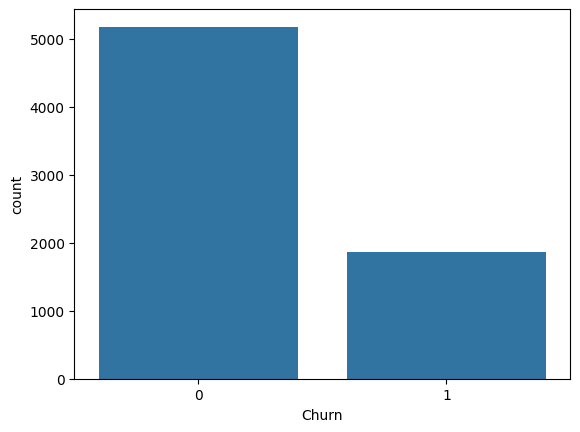

In [29]:
sns.countplot(x='Churn', data=con_dat)

From the graph above, we see that there appears some class imbalance in the dataset.  Since we observe class imbalance in the dataset, we need to take steps to ensure our model doesn't become biased toward the majority class. This imbalance can lead to misleading accuracy and poor performance in identifying actual churners. To address this, we can apply resampling techniques such as oversampling the minority class or undersampling the majority class. Additionally, we should use evaluation metrics like precision, recall, F1-score, and AUC rather than relying solely on accuracy. These steps will help create a more balanced and reliable churn prediction model.

#### Distribution of Numerical Features

We will now visualize the distribution of the numerical features in our dataset, first we will visualize the distributions and then generate a correlation matrix heatmap to visualize for multicollinearity.

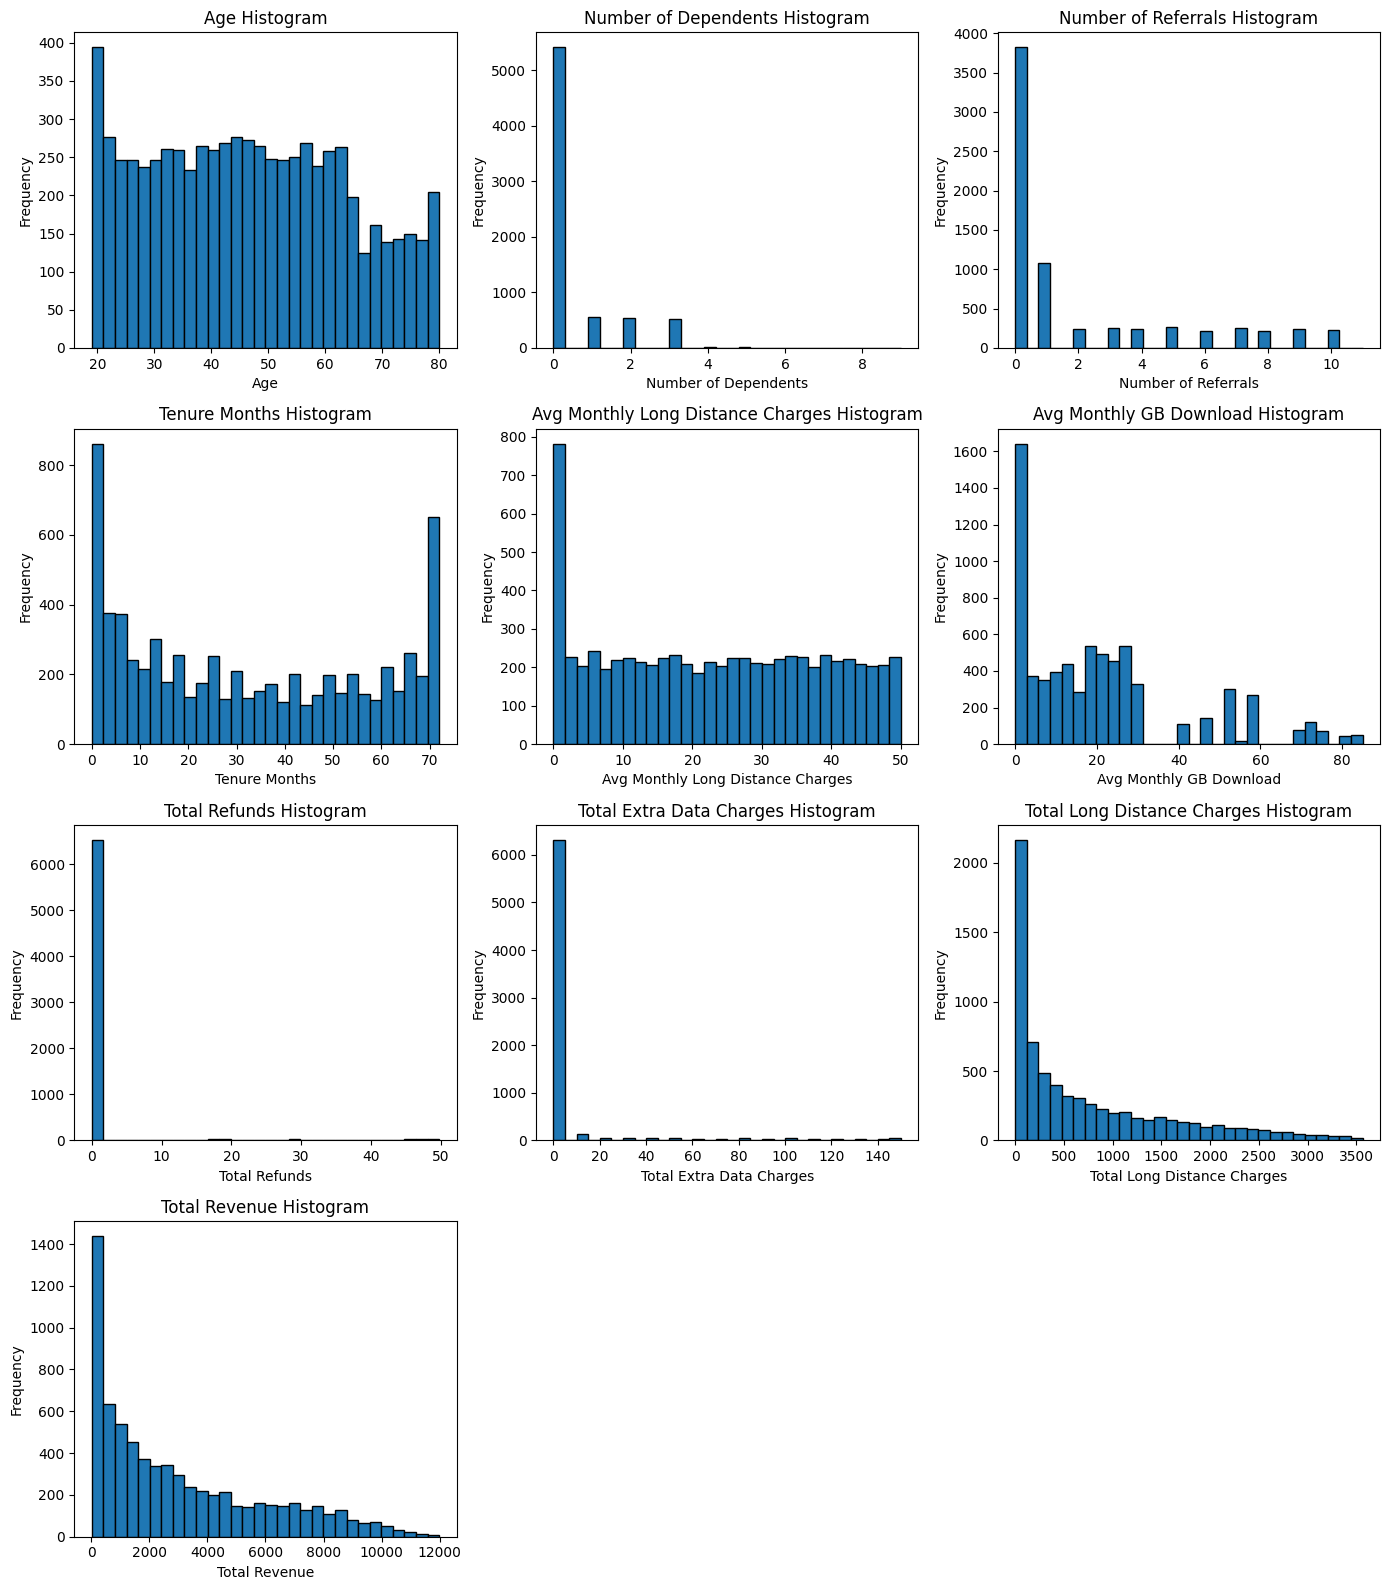

In [30]:
# --- NUMERICAL FEATURES ---
numeric_features = [
    'Age',
    'Number of Dependents',
    'Number of Referrals',
    'Tenure Months',
    'Avg Monthly Long Distance Charges',
    'Avg Monthly GB Download',
    'Total Refunds',
    'Total Extra Data Charges',
    'Total Long Distance Charges',
    'Total Revenue'
]

# --- HISTOGRAMS ---
import math
n = len(numeric_features)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows))
axes = axes.ravel()

for i, col in enumerate(numeric_features):
    ax = axes[i]
    ax.hist(con_dat[col].dropna(), bins=30, edgecolor='black')
    ax.set_title(f'{col} Histogram')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# remove any unused axes
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

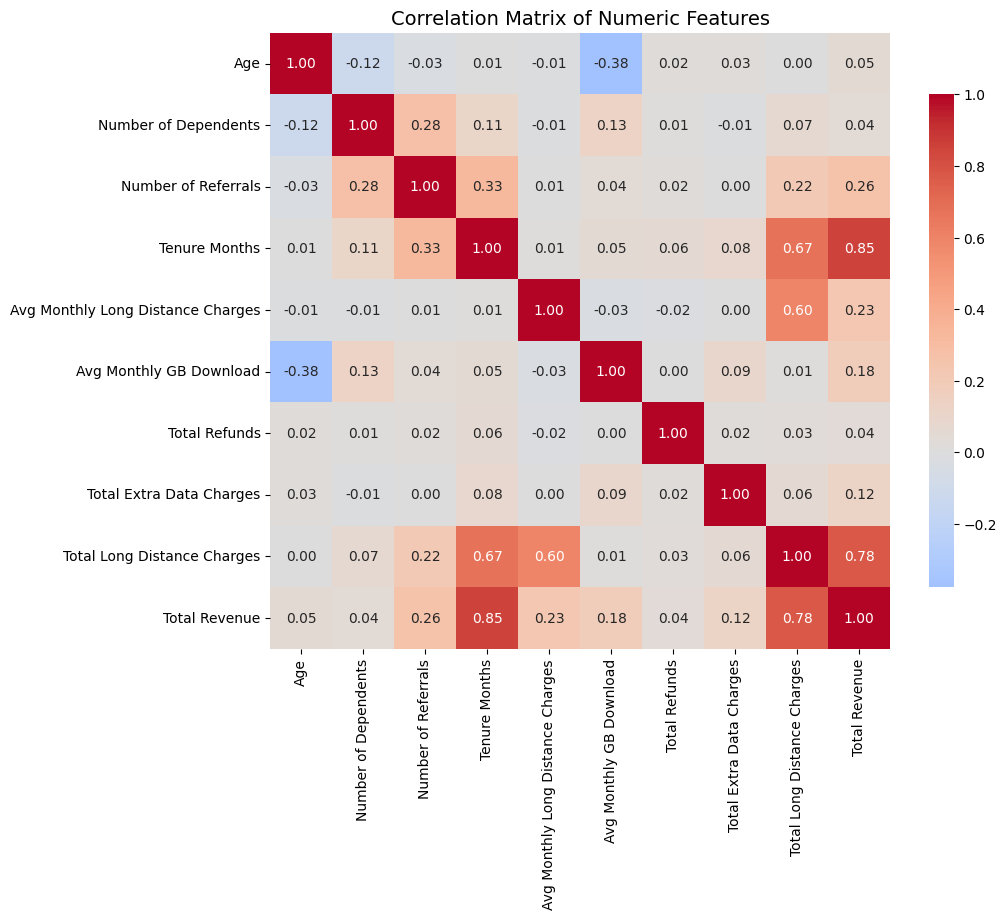

In [31]:
# --- Compute correlation matrix ---
corr_matrix = con_dat[numeric_features].corr()

# --- Plot heatmap ---
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix,
    annot=True, fmt=".2f", cmap="coolwarm", center=0,
    cbar_kws={'shrink': 0.8}
)
plt.title("Correlation Matrix of Numeric Features", fontsize=14)
plt.show()

From the graphs generated above, we see a lot of right-skewed distributions for many of the numerical features, with many of them peaking at **0**.  This might indicate that some of these features might not hold much predictive power.

Additionally, from the correlation heatmap generated, we see that some features as `Total Revenue`, `Tenure Months`, and `Total Long Distance Charges` are highly correlated with one another.  This can raise issues of multicollinearity and affect our model if we do decide to go with a regression based model, we will visualize the **VIF** or variance inflation factor to quantify whether there is a problem.  Usually **VIF > 10** is considered problematic.

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = con_dat[numeric_features].copy()
X = X.dropna()
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                             Feature        VIF
0                                Age   4.656460
1               Number of Dependents   1.398322
2                Number of Referrals   1.706741
3                      Tenure Months  11.217182
4  Avg Monthly Long Distance Charges   6.436871
5            Avg Monthly GB Download   2.108260
6                      Total Refunds   1.067303
7           Total Extra Data Charges   1.102250
8        Total Long Distance Charges   9.843789
9                      Total Revenue  12.375077


We see that **VIF > 10** for 2 features, `Tenure Months` and `Total Revenue`.  Since `Total Revenue` seems to be an aggregate of `Tenure Months` where `Total Revenue` seems to be a combination of money earned vs time, we will drop this feature and move forward after re-checking VIF after dropping.

In [33]:
con_dat.drop(columns=['Total Revenue'], inplace=True)

con_dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   object 
 1   Age                                7043 non-null   int64  
 2   Senior Citizen                     7043 non-null   object 
 3   Married                            7043 non-null   object 
 4   Dependents                         7043 non-null   object 
 5   Number of Dependents               7043 non-null   int64  
 6   Referred a Friend                  7043 non-null   object 
 7   Number of Referrals                7043 non-null   int64  
 8   Tenure Months                      7043 non-null   int64  
 9   Offer                              7043 non-null   object 
 10  Phone Service                      7043 non-null   object 
 11  Avg Monthly Long Distance Charges  7043 non-null   float

In [34]:
numeric_features = [
    'Age',
    'Number of Dependents',
    'Number of Referrals',
    'Tenure Months',
    'Avg Monthly Long Distance Charges',
    'Avg Monthly GB Download',
    'Total Refunds',
    'Total Extra Data Charges',
    'Total Long Distance Charges'
]

X = con_dat[numeric_features].copy()
X = X.dropna()

vif_data_cleaned = pd.DataFrame()
vif_data_cleaned["Feature"] = X.columns
vif_data_cleaned["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data_cleaned)

                             Feature       VIF
0                                Age  4.645151
1               Number of Dependents  1.357116
2                Number of Referrals  1.706632
3                      Tenure Months  7.262463
4  Avg Monthly Long Distance Charges  6.260172
5            Avg Monthly GB Download  1.891502
6                      Total Refunds  1.066099
7           Total Extra Data Charges  1.095272
8        Total Long Distance Charges  7.420275


Here the Vif is looking a lot better

#### Catgegorical Features Visualization

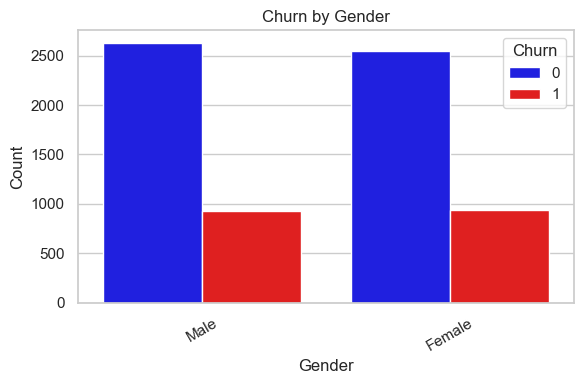

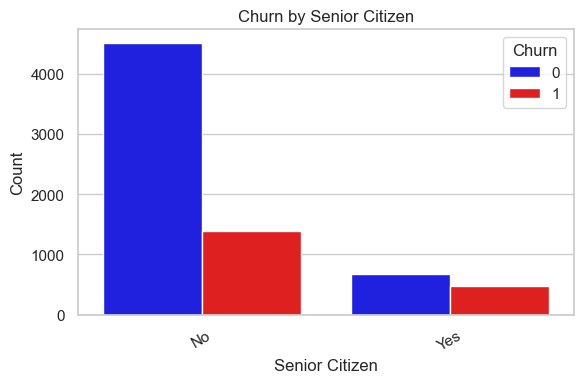

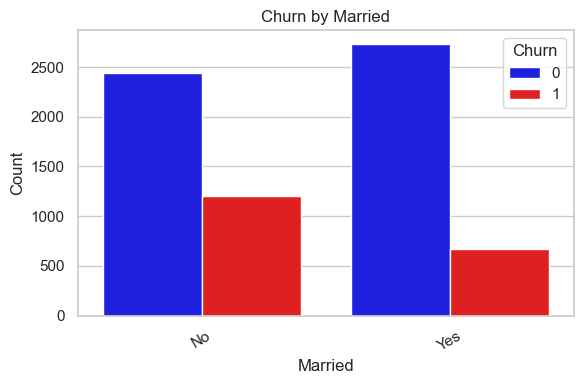

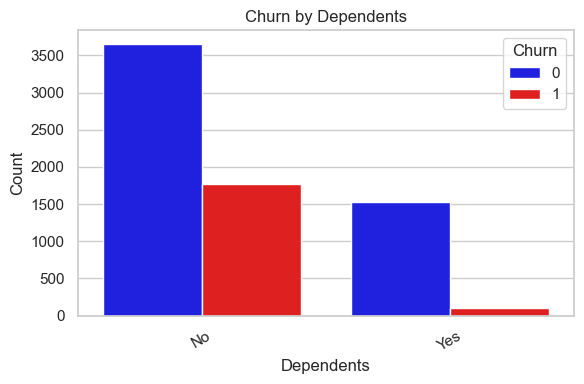

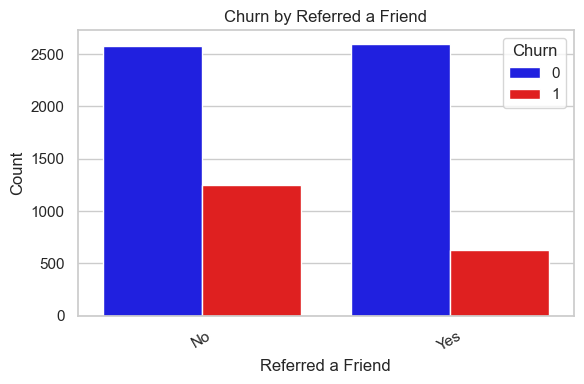

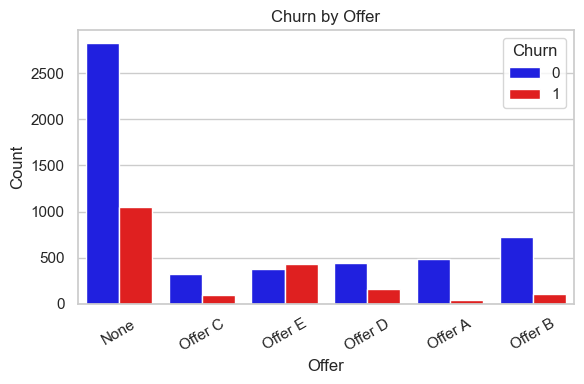

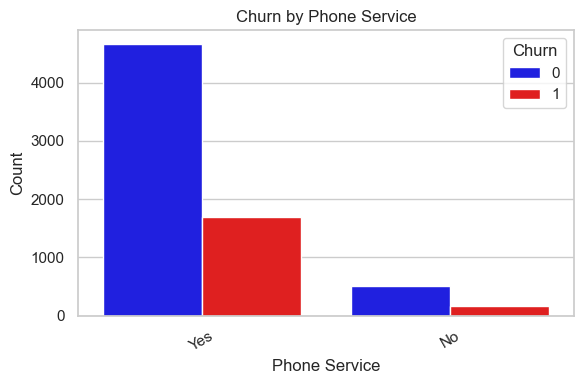

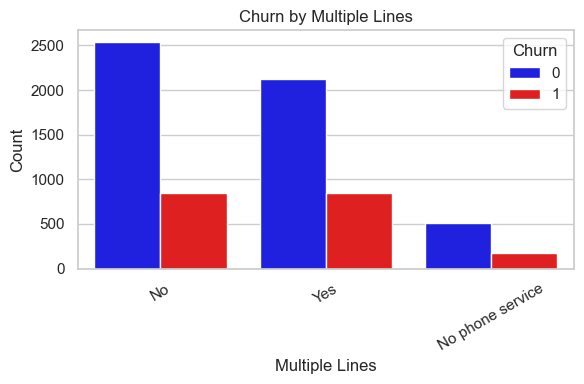

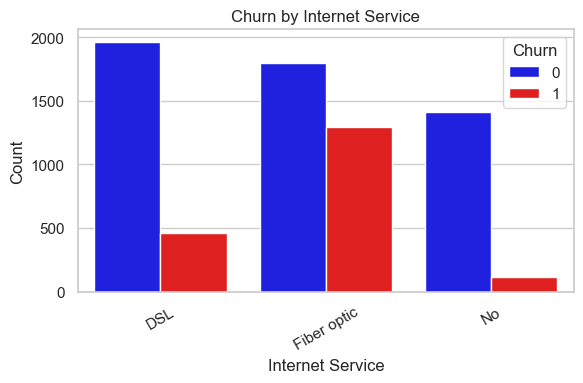

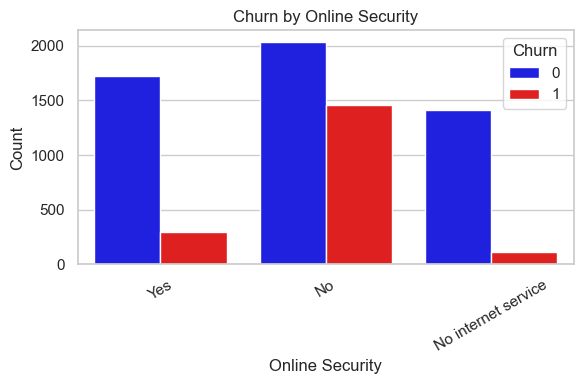

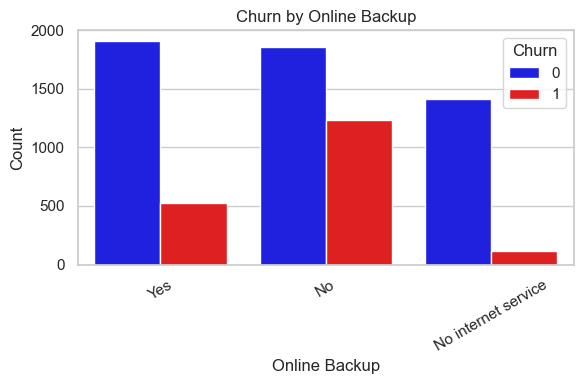

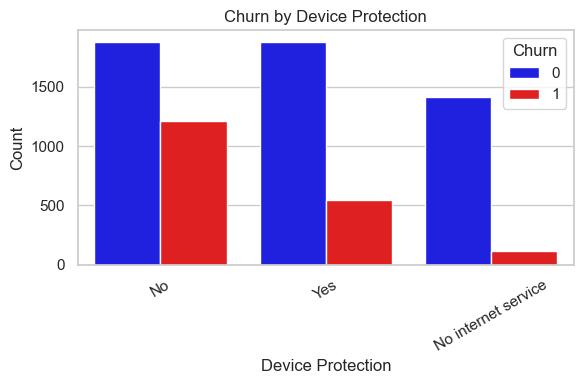

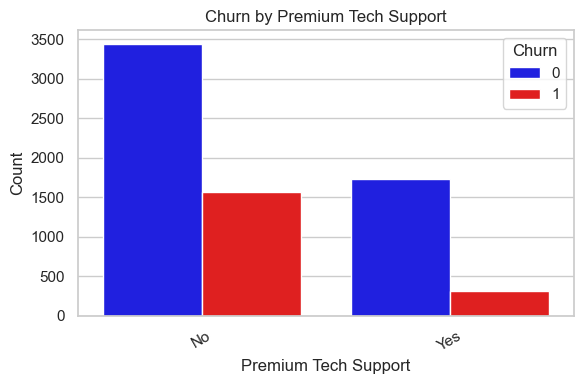

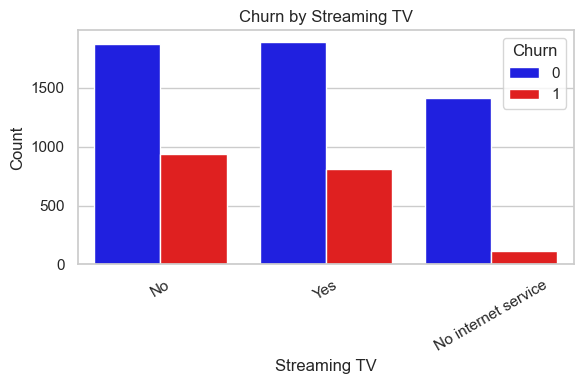

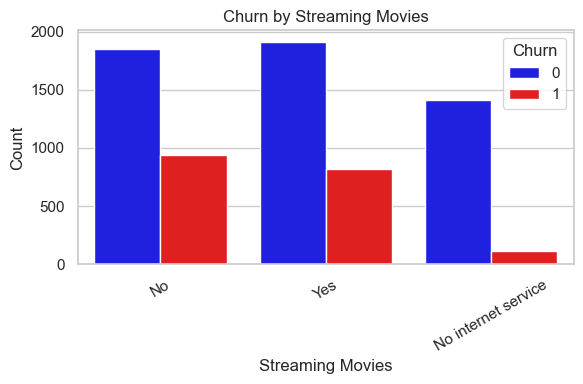

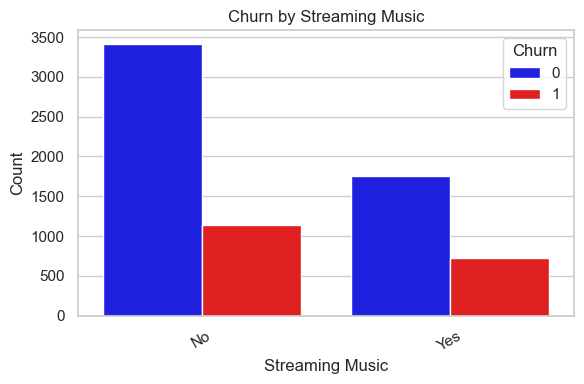

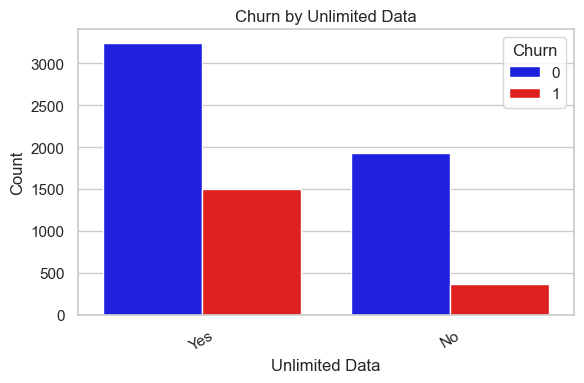

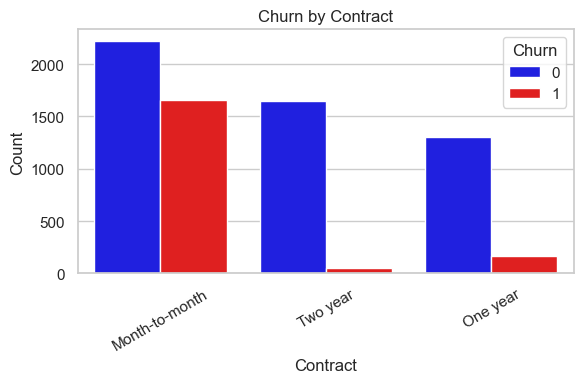

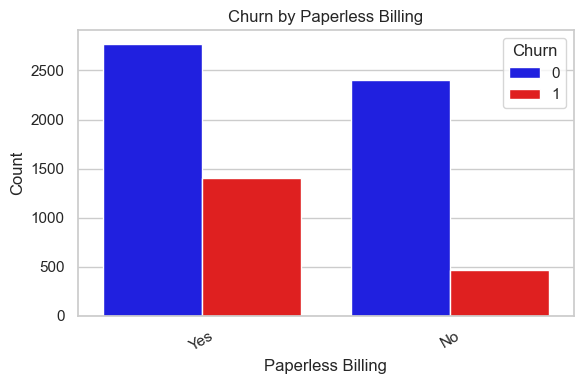

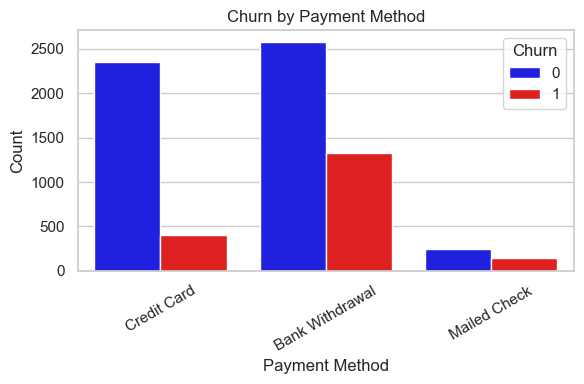

In [35]:
categorical_cols = [
    'Gender', 'Senior Citizen', 'Married', 'Dependents', 'Referred a Friend',
    'Offer', 'Phone Service', 'Multiple Lines', 'Internet Service',
    'Online Security', 'Online Backup', 'Device Protection',
    'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music',
    'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method'
]

# Set global plot style
sns.set(style="whitegrid")

# Plot each categorical variable vs Churn
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=con_dat, x=col, hue='Churn',
                  palette={0: 'blue', 1: 'red'})
    plt.title(f'Churn by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=30)
    plt.legend(title='Churn')
    plt.tight_layout()
    plt.show()

Above, we can sort of see some valuable information, like positive correlation between features such as `Phone Service`, `Dependents`, `Partner`, `Senior Citizen`, `Multiple Lines`, `Online Security`, `Online Backup`, `Device Protection`, `Tech Support`, `Contract`, `Paperless Billing`, and `Payment Method`.  The inverse of correlation could also be said for some features as well.  In all, this could lead to some statistical associations our model could pick up.

#### Categorical Variable Correlation Matrix

In [36]:
con_dat[categorical_cols].describe()

,Gender,Senior Citizen,Married,Dependents,Referred a Friend,Offer,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,2,6,2,3,3,3,3,3,2,3,3,2,2,3,2,3
top,Male,No,No,No,No,None,Yes,No,Fiber optic,No,No,No,No,No,No,No,Yes,Month-to-month,Yes,Bank Withdrawal
freq,3555,5901,3641,5416,3821,3877,6361,3390,3096,3498,3088,3095,4999,2810,2785,4555,4745,3875,4171,3909


Below we will generate a Cramer's V correlation matrix for categorical variables:

Cramér’s V is a statistical measure used to describe the strength of association between two categorical variables. Unlike Pearson’s correlation, which applies to numeric data, Cramér’s V is specifically designed for categorical–categorical relationships and is derived from the chi-squared test of independence. The value of Cramér’s V ranges between 0 and 1, where 0 indicates no association and 1 represents a perfect association. Because it is symmetric, the relationship between variable A and variable B is the same as that between B and A. In practice, lower values (close to 0) suggest a weak association, while higher values (closer to 1) suggest stronger associations. For example, in a churn analysis, variables like contract type or payment method may show higher Cramér’s V values with churn, highlighting their importance in explaining customer behavior.

In [37]:
from scipy.stats import chi2_contingency

main_color = ['#1f77b4', '#ff7f0e']  # Not Churn, Churn
cmp = 'Spectral'  # for seaborn heatmaps

# Function to compute Cramer's V
def cramers_v(confusion_matrix):
    """Bias-corrected Cramér's V (Bergsma & Wicher, 2013)."""
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    if n <= 1:
        return 0.0
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    if n == 1 or (n - 1) == 0:
        return 0.0
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    if denom <= 0:
        return 0.0
    return float(np.sqrt(phi2corr / denom))

def get_corr_mat(df_cat):
    """Return full pairwise Cramér's V matrix for categorical df (including 'Churn')."""
    cols = list(df_cat.columns)
    n = len(cols)
    dm = pd.DataFrame(np.eye(n), index=cols, columns=cols)  # 1s on diagonal
    for a, b in combinations(cols, 2):
        cont = pd.crosstab(df_cat[a], df_cat[b], margins=False).values
        v = cramers_v(cont)
        dm.loc[a, b] = v
        dm.loc[b, a] = v
    return dm

    
# ----------------- compact “vs Churn only” matrix -----------------
def get_churn_assoc(df, categorical_cols, churn_col='Churn'):
    """Return a 1-column DataFrame of Cramér's V vs churn for each categorical variable."""
    vals = []
    for col in categorical_cols:
        cont = pd.crosstab(df[col], df[churn_col], margins=False).values
        vals.append(cramers_v(cont))
    return pd.DataFrame({churn_col: vals}, index=categorical_cols)

# ----------------- your bar + heatmap viz (safer counting / % calc) -----------------
def cat_viz(list_of_var, df, churn_col='Churn'):
    # Build grouped counts using .size() (safe vs .count on a nullable column)
    bucket1, bucket2, bucket3, bucket4, bucket5 = [], [], [], [], []

    # optional: force explicit ordering of churn bars
    if df[churn_col].dtype != 'object':
        churn_order = [0, 1]
        churn_label = {0: 'Not Churn', 1: 'Churn'}
    else:
        churn_order = ['Not Churn', 'Churn']
        churn_label = {'Not Churn': 'Not Churn', 'Churn': 'Churn'}

    for var in list_of_var:
        # counts per (churn, category)
        g = df.groupby([churn_col, var]).size().reset_index(name='Count')
        # ensure both churn levels present
        # (optional) cast churn to categoricals for stable order
        g[churn_col] = g[churn_col].map(churn_label).astype('category')
        g[churn_col] = g[churn_col].cat.set_categories(['Not Churn', 'Churn'], ordered=True)

        # split into churn==1 and churn==0 counts aligned by categories
        # build a full index over categories to align both churn subsets
        cats = g[var].unique().tolist()

        g0 = g[g[churn_col] == 'Not Churn'].set_index(var).reindex(cats).fillna({'Count': 0})
        g1 = g[g[churn_col] == 'Churn'].set_index(var).reindex(cats).fillna({'Count': 0})

        # push into buckets in consistent order
        bucket1 += [var] * len(cats)
        bucket2 += cats
        bucket4 += g0['Count'].astype(int).tolist()  # Not Churn
        bucket3 += g1['Count'].astype(int).tolist()  # Churn

        # compute % within (Not Churn vs Churn) per category (i = not churn, j = churn)
        for i_cnt, j_cnt in zip(g0['Count'].tolist(), g1['Count'].tolist()):
            denom = i_cnt + j_cnt
            if denom == 0:
                bucket5.append([0.0, 0.0])
            else:
                bucket5.append([round(i_cnt/denom*100, 2), round(j_cnt/denom*100, 2)])

    # Build stacked bars
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=[bucket1, bucket2],
        y=bucket4,
        marker_color=main_color[0],
        name="Not Churn",
        text=[f"{j}<br>%{i[0]}" for i, j in zip(bucket5, bucket4)],
        hovertemplate="Var=%{x[0]}<br>Cat=%{x[1]}<br>Not Churn=%{y}<br>%=%{text}<extra></extra>"
    ))
    fig.add_trace(go.Bar(
        x=[bucket1, bucket2],
        y=bucket3,
        marker_color=main_color[1],
        name="Churn",
        text=[f"{j}<br>%{i[1]}" for i, j in zip(bucket5, bucket3)],
        hovertemplate="Var=%{x[0]}<br>Cat=%{x[1]}<br>Churn=%{y}<br>%=%{text}<extra></extra>"
    ))
    fig.update_layout(
        title_text="Demographics Categorical Data vs Churn",
        title_x=0.5, title_y=0.97,
        template='plotly_white',
        barmode='stack',
        xaxis_title=None, yaxis_title='Count'
    )

    # Full pairwise Cramér's V (vars + churn)
    cat_corr = get_corr_mat(df[list_of_var + [churn_col]])
    plt.figure(figsize=(min(1.2*len(cat_corr), 16), min(1.2*len(cat_corr), 16)))
    sns.heatmap(cat_corr, cbar=True, annot=True, fmt='.2f', square=True, annot_kws={'size': 10}, cmap=cmp)
    plt.title("Categorical Associations (Cramér's V)")
    plt.tight_layout()
    plt.show()

    return fig  # Plotly figure (bars)

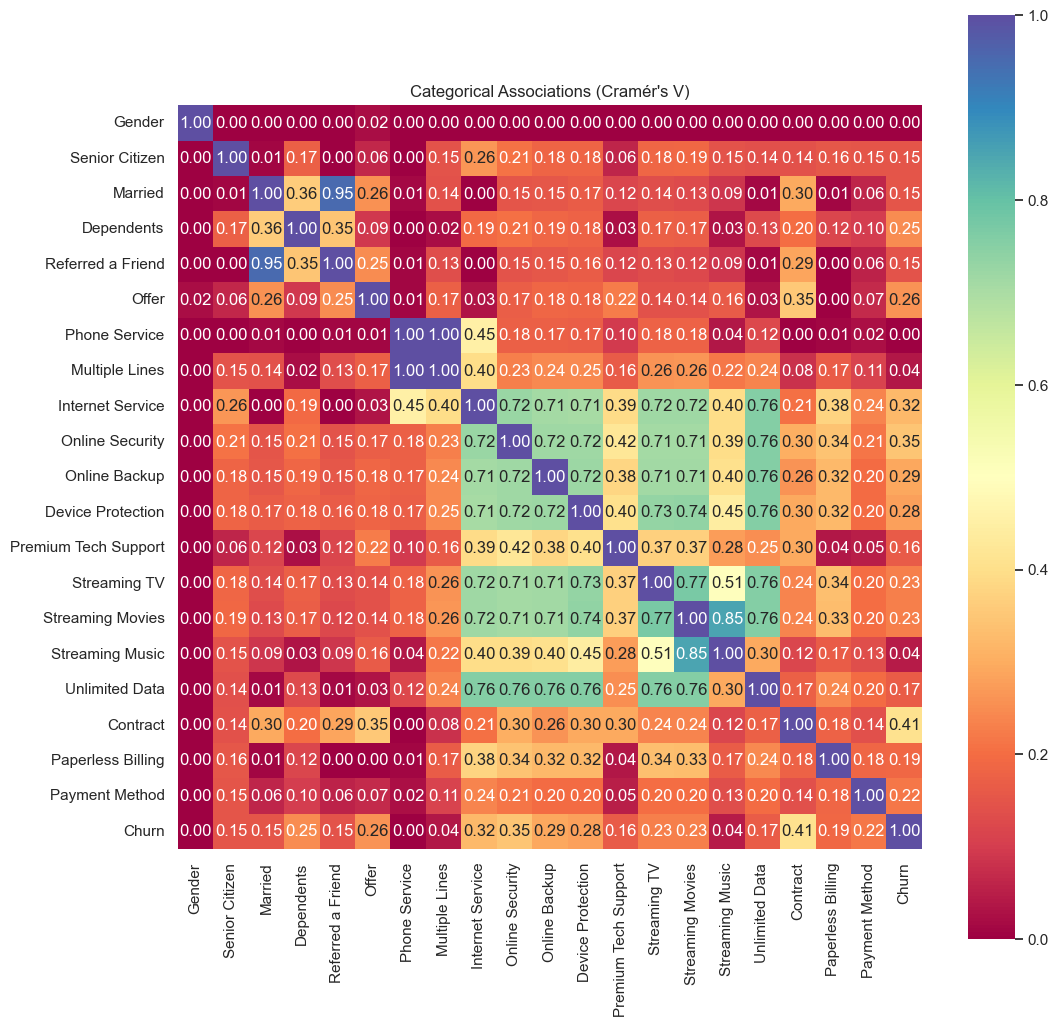

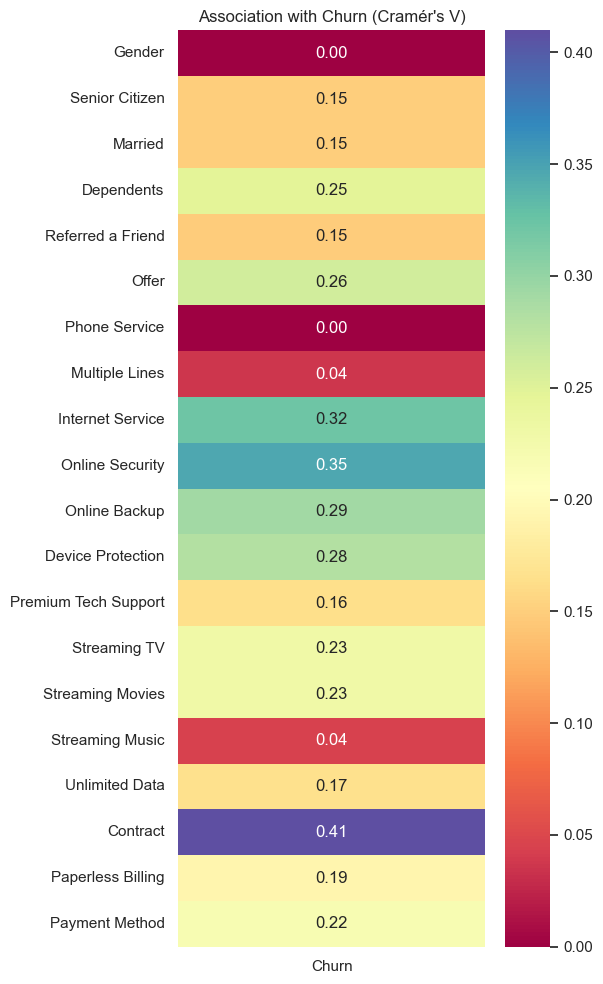

In [38]:
# 1) FULL pairwise heatmap (all categorical + Churn)
cat_corr = get_corr_mat(df[categorical_cols + ['Churn']])
plt.figure(figsize=(12, 12))
sns.heatmap(cat_corr, cbar=True, annot=True, fmt='.2f', square=True, cmap=cmp)
plt.title("Categorical Associations (Cramér's V)")
plt.show()

# 2) ONE-COLUMN “vs Churn” heatmap
one_col = get_churn_assoc(df, categorical_cols, churn_col='Churn')
plt.figure(figsize=(6, 10))
sns.heatmap(one_col, annot=True, fmt='.2f', cmap=cmp, cbar=True)
plt.title("Association with Churn (Cramér's V)")
plt.tight_layout()
plt.show()

In the pairwise, we see some features with high correlation: e.g. `Married` vs. `Referred a Friend` and `Streaming Movie` vs. `Streaming Music`.  However, since these are not aggregates and our main goal is prediction, we will keep these varaibles and move forward with it.  The 2nd pairwise created also further reinforces this idea.

### Data Cleaning

**Data Cleaning** is the process of identifying and correcting errors, inconsistencies, and inaccuracies in a dataset to improve its quality and ensure reliable analysis. This involves handling missing values, correcting data types, removing duplicate or irrelevant entries, standardizing formats, and resolving inconsistencies. Clean data is essential for building accurate and trustworthy models, as poor-quality data can lead to misleading insights and reduced model performance.

We will first split the data to prevent any **data-leakage** from occuring.  **Data Leakage** is the occurence when information from outside the training dataset unintentionally influences the model during training.  This can happen when preporcessing steps like scaling, encoding, or imputing are applied before the train-test split, or when target-related information is included in the features.  Data leakage leads to overly optimistic and overfitting results during evaluation; thus not generalizing well to real-world data and performance.

### Feature Engineering



#### Data Train/Test Split Creation

We will be splitting the data into a 80/20 test split

In [44]:
from sklearn.model_selection import train_test_split

# Creating dataset with without target
X = con_dat.drop('Churn', axis=1)
# Creating dataset with target
y = con_dat['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

## Baseline Model

Before applying preprocessing and utilizing a variety of different models, we will create a baseline model so we have something to compare our preprocessed complex model against.

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

X_train_enc = pd.get_dummies(X_train, drop_first=True)
X_test_enc  = pd.get_dummies(X_test, drop_first=True)

X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

baseline_model = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1)
baseline_model.fit(X_train_enc, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [46]:
y_pred = baseline_model.predict(X_test_enc)
y_proba = baseline_model.predict_proba(X_test_enc)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

[[820 215]
 [ 70 304]]
              precision    recall  f1-score   support

           0     0.9213    0.7923    0.8519      1035
           1     0.5857    0.8128    0.6809       374

    accuracy                         0.7977      1409
   macro avg     0.7535    0.8026    0.7664      1409
weighted avg     0.8323    0.7977    0.8065      1409

ROC-AUC: 0.8766565914903512


#### One Hot Encoding

Below we will be One-Hot Encoding our Categorical Variables to help create values for our ML-based model.

In [47]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

encoder = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

#### Standard Scaler

Below we will also be importing a Standard Scaler, this normalizes our data to be normally distributied with means centered around 0.

In [48]:
from sklearn.preprocessing import StandardScaler

new_numeric_features = [
    'Latitude',
    'Longitude',
    'Tenure Months',
    'Monthly Charges',
    'Churn Score',
    'CLTV'
]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), new_numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)